**Fully Connected NN and Saving-Loading Models**


---



*Building ANN model*

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms

# Create a transform to be applied to each sample
transform1 = transforms.Compose([
    transforms.ToTensor(),  # converts PIL image or numpy array (HxWxC) into a 
                            #   torch.FloatTensor (CxHxW), scales it to [0,1] 
    transforms.Normalize(mean=[0.5],std=[0.5]) # for 1 channel
                            #   [0.5,0.5,0.5] for 3 channels
                            # Conversion from RGB to gray could also be useful
                            # Transforms can also be added to the dataloader
    ])

# Download the dataset and apply the transform for each sample
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = transform1
    )

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform = transform1
    )

torch.Size([28, 28]) tensor(255, dtype=torch.uint8)


Text(0.5, 1.0, '5 - five')

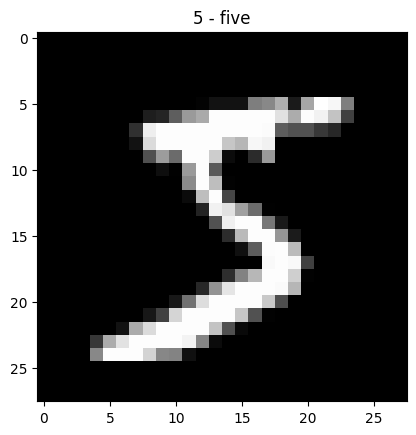

In [2]:
from matplotlib import pyplot as plt

# Take a look at a sample
sample_id = 0
image = train_data.data[sample_id]        
label = train_data.targets[sample_id]

print(image.shape, image.max())     # Note: image is not yet reshaped or normalized

plt.imshow(image, cmap="gray")      # .squeeze() if img.shape is (1,28,28)
plt.title(train_data.classes[label.item()])



*Define a fully connected model*

In [3]:
# First, do it with nn.Sequential()
import torch.nn as nn

MyModel1 = nn.Sequential(
    nn.Flatten(start_dim=1),    # To preserve batch_size, start_dim=1 (default)
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

print(MyModel1)
print(MyModel1[1])  # Access a specific layer of the model


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)
Linear(in_features=784, out_features=512, bias=True)


In [4]:
# NOTE: nn.Flatten() has default start_dim 1
# That means, it will preserve the batch size; for instance:
input = torch.randn(32, 1, 5, 5)
m = nn.Flatten()
output = m(input)
output.size()

torch.Size([32, 25])

In [5]:
# Second, do it as nn.Module class
import torch.nn as nn

# A fully connected model
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)

        # When .view() is used, you should preserve the batch size:
        # batch_size = x.size(0)
        # x.view(batch_size,-1)
        
        logits = self.linear_relu_stack(x)
        return logits


*Set the device*

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel2().to(device)   # send the model to device

print(model) #check out the model

MyModel2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


*Pass a random input to check the model*

In [18]:
# single input
x = torch.randn((1,28,28),dtype=torch.float32)
x = x.to(device)    # the model and input should be on the same device!
y_pred = model(x)
print(y_pred.shape)

# batch input
x = torch.randn((32,1,28,28),dtype=torch.float32)
x = x.to(device)    # the model and input should be on the same device!
y_pred = model(x)
print(y_pred.shape)



torch.Size([1, 10])
torch.Size([32, 10])


In [21]:
# repeat the above with the first model
# batch input
x = torch.randn((32,1,28,28),dtype=torch.float32)
x = x.to(device)    
# y_pred = MyModel1(x) # This will give error b/c MyModel1 is not send to device
y_pred = MyModel1.to(device)(x)
print(y_pred.shape)


torch.Size([32, 10])


*Create dataloader*

In [22]:
from torch.utils.data import DataLoader #creates an iterable around a dataset

batch_size = 64

train_dataloader = DataLoader(train_data,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size,shuffle=False)

*Set the loss function*

In [23]:
loss_fn = nn.CrossEntropyLoss()

*Set the optimizer*

In [24]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

*Train the model*

In [ ]:
num_epochs = 100

# Put the model in training mode
model.train()

for epoch in range(num_epochs):
  for X,y in train_dataloader:

    # Send to device
    X = X.to(device)  
    y = y.to(device)

    # Make a prediction
    y_pred = model(X)

    # Compute loss
    loss = loss_fn(y_pred,y)

    # Zero the gradients
    optimizer.zero_grad()

    # Propagate loss backward
    loss.backward()

    # Update the parameters
    optimizer.step()

  print(f"Epoch: {epoch}/{num_epochs}, Loss: {loss.item():0.4f}")


*Test the model*

In [ ]:
# Put the model in test mode
model.eval()

# Initialize some parameters to get the loss values
total_loss = 0
total_correct = 0
dataset_size = len(test_dataloader.dataset)

# Gradients will not be calculated
with torch.no_grad():
  for X,y in test_dataloader:
    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)

    # Calculate loss
    total_loss += loss_fn(y_pred, y).item()
    total_correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
  
  print(f"Accuracy: {total_correct/dataset_size:0.4f}, Avg loss: {total_loss/dataset_size:0.4f}")

Accuracy: 0.8213, Avg loss: 0.0078


*Check out the model on a single input*

Text(0.5, 1.0, 'Trouser')

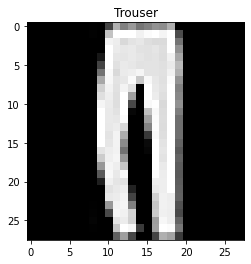

In [ ]:
X,y = next(iter(test_dataloader))
X = X.to(device)
y = y.to(device)

# Get a specific sample
sample_id = 2
X0 = X[sample_id]
y0 = y[sample_id]

# Make the prediction. It is of vector size 10; get the argmax
y_pred = model(X0).argmax(1)

# The shape is (1,28,28). Convert it to (28,28)
#print(X0.shape)
#print(X0.squeeze().shape)

# After squeezing, move it to cpu, convert to numpy, and gray scale 
plt.imshow(X0.squeeze().cpu().numpy(), cmap="gray")
plt.title(train_data.classes[y_pred.item()])

*Save the model*

In [ ]:
# Save a model
torch.save(model.state_dict(), "model.pth")

# Load a model
model = MyModel2()
model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>